# 目录
* Tensorboard数据形式
* Tensorboard可视化过程
* Tensorboard实例一（helloWorld）
* Tensorboard实例二

Tensorboard是Tensorflow官方推出**可视化工具**，它可以将模型训练过程中的各种数据汇总起来存在自定义的路径与日志文件中，然后在指定的web端可视化地展现这些信息。

## 1、 Tensorboard的数据形式
Tensorboard可以记录与展示以下数据形式：   
（1）标量Scalars   
（2）图片Images   
（3）音频Audio   
（4）计算图Graph   
（5）数据分布Distribution   
（6）直方图Histograms   
（7）嵌入向量Embeddings  
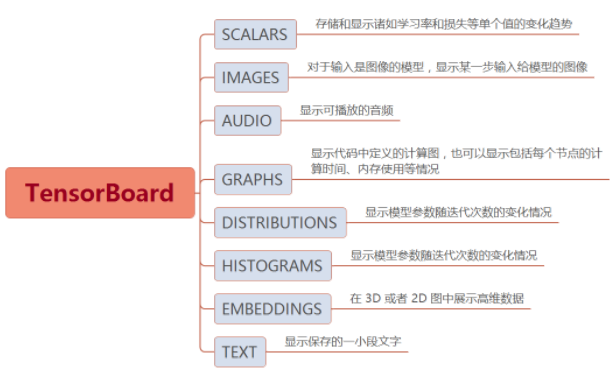

## 2 、Tensorboard的可视化过程
（1）首先肯定是先建立一个graph,你想从这个graph中获取某些数据的信息

（2）确定要在graph中的哪些节点放置summary operations以记录信息 

使用tf.summary.scalar记录标量   
使用tf.summary.histogram记录数据的直方图   
使用tf.summary.distribution记录数据的分布图  
...

（3）使用tf.summary.merge_all去将所有summary节点合并成一个节点

（4）使用tf.summary.FileWriter将运行后输出的数据都保存到本地磁盘中

（5）运行整个程序，并在命令行输入运行tensorboard的指令，之后打开web端可查看可视化的结果

## 3、Tensorboard示例一

In [2]:
import tensorflow as tf

# 定义一个简单的计算图，实现向量加法的操作。
input1 = tf.constant([1.0, 2.0, 3.0], name = 'input1')
input2 = tf.Variable(tf.random_uniform([3]), name = 'input2')
output = tf.add_n([input1, input2], name = 'add')

# 生成一个写日志的writer，并将当前的tensorflow计算图写入日志。
# tensorflow提供了多种写日志文件的API
writer = tf.summary.FileWriter('/home/lidan/logfile/toy', tf.get_default_graph())
writer.close()

**Tensorboard启动**  
在命令行运行：
tensorboard --logdir=/home/lidan/logfile/toy

在web端访问：192.168.1.219：6006，显示tensorflow计算图如下：
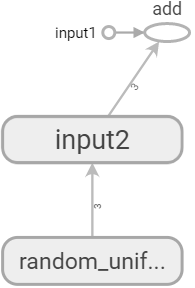


## 4、Tensorboard示例二

In [1]:
# XOR，注意：该代码只能运行一次，运行第二次前需要重启kernel清理内存，否则会报错
import tensorflow as tf
import numpy as np

tf.set_random_seed(777)  # for reproducibility
learning_rate = 0.01

x_data = [[0, 0],
          [0, 1],
          [1, 0],
          [1, 1]]
y_data = [[0],
          [1],
          [1],
          [0]]
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

X = tf.placeholder(tf.float32, [None, 2], name='x-input')
Y = tf.placeholder(tf.float32, [None, 1], name='y-input')

with tf.name_scope("layer1") as scope:
    W1 = tf.Variable(tf.random_normal([2, 2]), name='weight1')
    b1 = tf.Variable(tf.random_normal([2]), name='bias1')
    layer1 = tf.sigmoid(tf.matmul(X, W1) + b1)

    w1_hist = tf.summary.histogram("weights1", W1)
    b1_hist = tf.summary.histogram("biases1", b1)
    layer1_hist = tf.summary.histogram("layer1", layer1) #第一层输出直方图


with tf.name_scope("layer2") as scope:
    W2 = tf.Variable(tf.random_normal([2, 1]), name='weight2')
    b2 = tf.Variable(tf.random_normal([1]), name='bias2')
    hypothesis = tf.sigmoid(tf.matmul(layer1, W2) + b2)

    w2_hist = tf.summary.histogram("weights2", W2)
    b2_hist = tf.summary.histogram("biases2", b2)
    hypothesis_hist = tf.summary.histogram("hypothesis", hypothesis) #第二层输出直方图

# cost/loss function
with tf.name_scope("cost") as scope:
    cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                           tf.log(1 - hypothesis))
    cost_summ = tf.summary.scalar("cost", cost) #损失标量

with tf.name_scope("train") as scope:
    train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)#cast 概率为0/1
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))#tf.equal返回true/false向量
accuracy_summ = tf.summary.scalar("accuracy", accuracy) #准确率标量

# Launch graph
with tf.Session() as sess:
    # tensorboard --logdir=./logs/xor_logs
    merged_summary = tf.summary.merge_all() #合并所有记录数据
    writer = tf.summary.FileWriter("/home/lidan/logfile/XOR")
    writer.add_graph(sess.graph)  # Show the graph 将记录的数据以graph的形式写入本地磁盘

    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in range(10001):
        summary, _ = sess.run([merged_summary, train], feed_dict={X: x_data, Y: y_data})
        writer.add_summary(summary, global_step=step)

        if step % 2000 == 0:
            print('step:',step, 'cost:',sess.run(cost, feed_dict={
                  X: x_data, Y: y_data}), 'W1, W2:',sess.run([W1, W2]),'b1,b2:',sess.run([b1,b2]))
            print('layer1:',sess.run([layer1],feed_dict={X: x_data, Y: y_data}),'\n')
            print('hypothesis:',sess.run([hypothesis],feed_dict={X: x_data, Y: y_data}),'\n')

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data, Y: y_data})
    print("\nHypothesis: ", h, "\nCorrect: ", c, "\nAccuracy: ", a)


'''
Hypothesis:  [[  6.13103184e-05]
 [  9.99936938e-01]
 [  9.99950767e-01]
 [  5.97514772e-05]]
Correct:  [[ 0.]
 [ 1.]
 [ 1.]
 [ 0.]]
Accuracy:  1.0
'''


step: 0 cost: 0.715638 W1, W2: [array([[ 0.79269588,  0.68861037],
       [-1.20728338, -0.29517072]], dtype=float32), array([[ 1.7177    ],
       [ 0.35572484]], dtype=float32)] b1,b2: [array([ 0.46847814, -0.93401575], dtype=float32), array([-1.29351115], dtype=float32)]
layer1: [array([[ 0.61502349,  0.28211072],
       [ 0.32326546,  0.22632384],
       [ 0.77922809,  0.43895471],
       [ 0.5134694 ,  0.36805359]], dtype=float32)] 

hypothesis: [array([[ 0.46587032],
       [ 0.34124994],
       [ 0.55011022],
       [ 0.43030691]], dtype=float32)] 

step: 2000 cost: 0.00630939 W1, W2: [array([[ 6.62234449, -7.19256687],
       [-7.08543158,  7.52679777]], dtype=float32), array([[ 11.22315693],
       [ 10.81134701]], dtype=float32)] b1,b2: [array([-3.65039492, -4.17788649], dtype=float32), array([-5.45383358], dtype=float32)]
layer1: [array([[  2.53229532e-02,   1.50993895e-02],
       [  2.17510551e-05,   9.66069102e-01],
       [  9.51290727e-01,   1.15310813e-05],
       [  1

'\nHypothesis:  [[  6.13103184e-05]\n [  9.99936938e-01]\n [  9.99950767e-01]\n [  5.97514772e-05]]\nCorrect:  [[ 0.]\n [ 1.]\n [ 1.]\n [ 0.]]\nAccuracy:  1.0\n'

**Tensorboard启动**    
在命令行运行：
tensorboard --logdir=/home/lidan/logfile/XOR

在web端访问：192.168.1.219：6006

**GRAPH**：展示网络整体结构，显示数据流的方向和大小，也可以显示训练时每个节点的用时、耗费的内存大小以及参数多少。
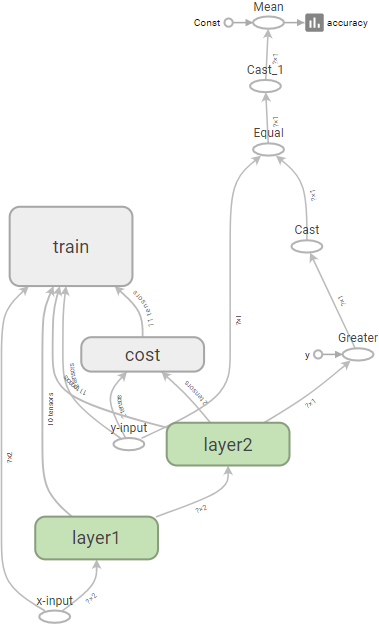

**SCALAR：**SCALARS 面板主要用于记录诸如准确率、损失和学习率等单个值的变化趋势。
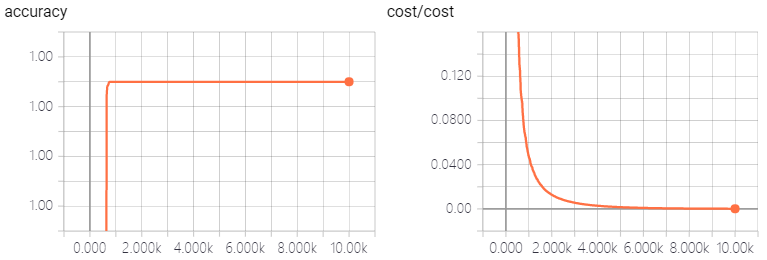

**DISTRIBUTION：**
DISTRIBUTIONS 主要用来展示网络中各参数随训练步数的增加的变化情况。
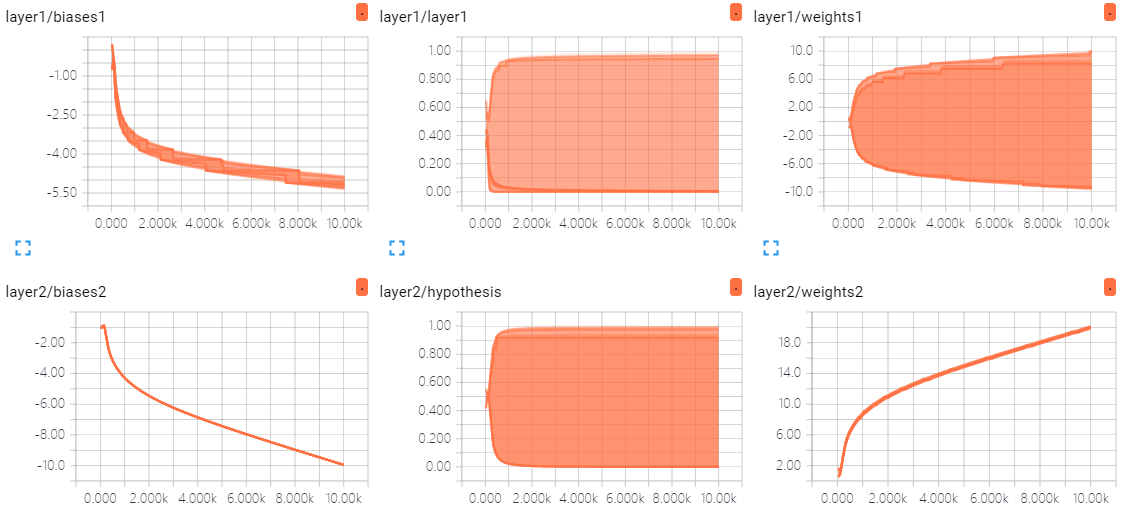

**HISTOGRAM：**
横轴表示权重值，纵轴表示训练步数。颜色越深表示时间越早，越浅表示时间越晚（越接近训练结束）。除此之外，HISTOGRAMS 还有个 Histogram mode，有两个选项：OVERLAY 和 OFFSET。选择 OVERLAY 时横轴为权重值，纵轴为频数，每一条折线为训练步数。颜色深浅与上面同理。默认为 OFFSET 模式。
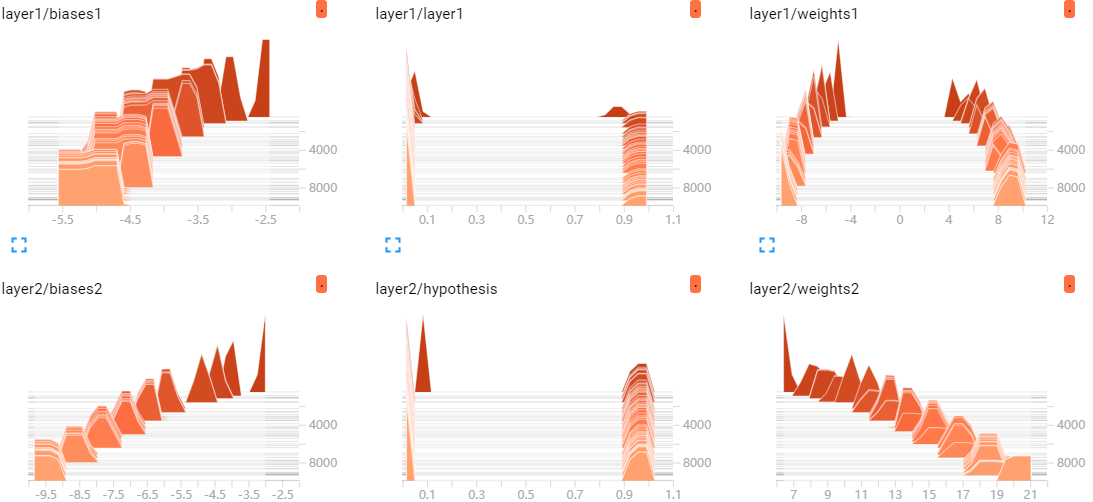

## 5、参考文献

http://blog.csdn.net/sinat_33761963/article/details/62433234

https://vimsky.com/article/3645.html

https://www.tensorflow.org/get_started/tensorboard_histograms